In [ ]:
# Load packages; 
import time
import numpy as np
import matplotlib.pyplot as plt

# Train using pytorch
import torch
import torch.nn as nn
from tqdm import tqdm

use_cuda = True
if torch.cuda.is_available() and use_cuda:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
def to_device(list_of_arrays):
    return [torch.Tensor(array).to(device) for array in list_of_arrays]

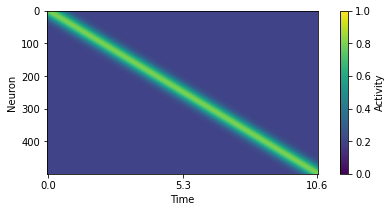

In [ ]:
# Generate target

# Number of neurons
dim_rec = 500
# Time step, max time of target
dt_target = 0.0641
t_max_target = 166 * dt_target
# Width of bump
bump_width = 0.035

# Generate moving bump
target_t = np.arange(0, t_max_target, dt_target)
n_t_target = len(target_t)
rel_idx = np.arange(dim_rec) / dim_rec
rel_time = target_t / t_max_target
target_R = np.exp(-(rel_idx[:, None] - rel_time[None, :])**2 / 
                  (2 * bump_width**2))

# The target is rates, which have range (0, 1). 
# Shift min and max so that there's no saturation.
min_r = 0.2
max_r = 0.8
target_R = (max_r - min_r) * target_R + min_r

# Plot target function
fig = plt.figure()
ax = fig.subplots(1, 1)
im = ax.imshow(target_R, aspect=0.2, vmin=0, vmax=1)
plt.colorbar(im, label="Activity")
# Label x axis so that the labels show the actual time.
nt = len(target_t)
xticks = np.array([0, nt//2, nt-1])
ax.set_xticks(xticks)
ax.set_xticklabels(["%.1f" % tt for tt in target_t[xticks]])
ax.set_xlabel("Time")
ax.set_ylabel("Neuron")
plt.show(fig)
plt.close(fig)

In [ ]:
# Network parameters
# Number of neurons must match the target function!
dim_rec = target_R.shape[0]
# Neural noise std dev
noise_std = 0.01
# Time scale of neuron
tau = 0.01
# Standard deviation of initial weights (scaled by sqrt(N))
g = 1.5

# Define time steps for integration and recording. 
# The rates are only compared to the target rates at recorded epochs. 
# The target array defines the recording time step
dt_rec = np.diff(target_t)[0]
assert np.allclose(np.diff(target_t), dt_rec)
# We would like something close to dt = 0.001 (cf.  Kanaka's code) 
rec_step = 50
dt = dt_rec / rec_step

# Times: make sure to have equivalent arrays for target and recurrent dynamics
t_max = target_t[-1] + dt_rec
t = np.arange(0, t_max, dt)
n_t = len(t)

# Nonlinearity
nonlinearity = 'logistic' 
phi = lambda x: 1 / (1 + np.exp(-x))
inv_phi = lambda y: np.log(y / (1 - y))

# Additional input
ampIn = 1.
tauWN = 1.
ampWN = np.sqrt(tauWN / dt)
iWN = ampWN*np.random.randn(n_t, dim_rec)
input = np.ones((n_t, dim_rec))
for tt in range(1, n_t):
    input[tt] = iWN[tt] + (input[tt - 1] - iWN[tt])*np.exp(- (dt / tauWN))
input *= ampIn

In [ ]:
# Define network class
class RNN(nn.Module):
    def __init__(self, dim_rec, noise_std, dt, tau, g, nonlinearity="logistic",
                 wrec=None):
        """
        RNN model for training.
        dim_rec:        number of neurons
        noise_std:      neural noise standard deviation
        dt:             integration time step
        tau:            neural time scale
        g:              std dev of initial recurrent weights
        nonlinearity:   nonlinearity transforming state to rate; currently
                        only the logistic function is implemented.
        wrec:           specify the recurrent weights; this will overwrite `g`
        """
        super(RNN, self).__init__()
        self.dim_rec = dim_rec
        self.noise_std = noise_std
        self.dt = dt
        self.tau = tau
        
        # Nonlinearity
        if nonlinearity == 'logistic':
            self.nonlinearity = lambda x: 1. / (1. + torch.exp(-x))
            
        # Define and initilize parameters
        self.wrec = nn.Parameter(torch.Tensor(dim_rec, dim_rec))

        # Initialize parameters
        with torch.no_grad():
            # Recurrent weights
            if wrec is None:
                self.wrec.normal_(std=g/np.sqrt(dim_rec))
            else:
                if type(wrec) == np.ndarray:
                    wrec = torch.from_numpy(wrec)
                self.wrec.copy_(wrec)
            
            
    def forward(self, input, h_init, rec_step):
        """
        input:      tensor of shape (batch_size, #timesteps, dim_rec)
                    Important: the 3 dimensions need to be present, 
                    even if they are of size 1.
        h_init:     initial state, must be of shape (batch_size, dim_rec)
        rec_step:   step size at which neural rates are recorded. 
                    Note that they will be recorded whenever 
                        i % rec_step == rec_step - 1
                    This means that the input and targets samples must be 
                    shifted correspondingly (as done in the code below)!        
        """
        batch_size = input.shape[0]
        seq_len = input.shape[1]
        
        # Noise
        noise = torch.randn(batch_size, seq_len, self.dim_rec, 
                            device=self.wrec.device)
        
        # Results vector
        # Only record every rec_step
        rec_seq_len = seq_len // rec_step
        rates = torch.zeros(batch_size, rec_seq_len, self.dim_rec, 
                            device=self.wrec.device)

        # Simulation loop
        h = h_init
        dt_tau = self.dt / self.tau
        for i in range(seq_len):
            rec_input = (
                self.nonlinearity(h).matmul(self.wrec.t()) 
                + input[:, i, :]
                )
            h = ((1 - dt_tau) * h 
                 + dt_tau * rec_input
                 + np.sqrt(dt_tau) * self.noise_std * noise[:, i, :])
            # Save
            if i % rec_step == rec_step-1:
                k = i // rec_step
                rates[:, k, :] = self.nonlinearity(h)

        return rates

In [ ]:
# Initialize network
net = RNN(dim_rec, noise_std, dt, tau, g, nonlinearity)
net.to(device=device)
    
# Obtain initial network activity
h_init_full = target_R.T[0][None]
input_full = input[None]
h_init_full = torch.from_numpy(np.float32(h_init_full)).to(device)
input_full = torch.from_numpy(np.float32(input_full)).to(device)
with torch.no_grad():
    rates_init = net(input_full, h_init_full, rec_step=1)
    rates_init = rates_init.detach().cpu().numpy()[0]

# Save initial weights
wrec_init = net.wrec.detach().cpu().numpy().copy()

In [ ]:
# Training
n_epochs = 500
learning_rate = 0.01

# Loss
loss_criterion = torch.nn.MSELoss().to(device)
# Optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    
# To simplify training, we will separate the target array into smaller samples
# A batch consists of randomly chosen samples
batch_size = 64
n_targets = len(target_t)
n_targets_per_sample = 5
n_t_per_sample = n_targets_per_sample * rec_step
# To construct a sample, choose a target i. This will be the initial condition
# The sample starts at the time step after the target, 
# and ends at the target i + n_targets_per_sample
# The max index is thus
max_idx = n_targets - n_targets_per_sample - 1
    
# Results
losses = np.zeros((n_epochs))

# Convert input and target from double to float (for torch)
target_R = np.float32(target_R)
input = np.float32(input)

print("Training...")
time0 = time.time()
for i_epoch in tqdm(range(n_epochs)):
    
    # Inputs and targets for this batch
    t_batch = np.zeros((batch_size, n_t_per_sample))
    h_init_batch = np.zeros((batch_size, dim_rec), dtype=np.float32)
    input_batch = np.zeros((batch_size, n_t_per_sample, dim_rec), dtype=np.float32)
    target_batch = np.zeros((batch_size, n_targets_per_sample, dim_rec), dtype=np.float32)
    # Choose indices at random
    idxs = np.random.choice(max_idx, batch_size, replace=max_idx < batch_size)
    for i_batch in range(batch_size):
        idx = idxs[i_batch]
        # Initial condition
        h_init_batch[i_batch] = inv_phi(target_R.T[idx])
        # Times and input
        idx_t0 = idx * rec_step + 1
        idx_t1 = idx_t0 + n_t_per_sample
        t_batch[i_batch] = t[idx_t0 : idx_t1]
        input_batch[i_batch] = input[idx_t0 : idx_t1]
        # Target
        idx_0 = idx + 1
        idx_1 = idx_0 + n_targets_per_sample
        target_batch[i_batch] = target_R.T[idx_0 : idx_1]
    # To torch, and allocate
    h_init_batch = torch.from_numpy(h_init_batch).to(device)
    input_batch = torch.from_numpy(input_batch).to(device)
    target_batch = torch.from_numpy(target_batch).to(device)

    # Run network
    optimizer.zero_grad()
    output = net(input_batch, h_init_batch, rec_step)
    loss = loss_criterion(output, target_batch)

    # Gradient descent
    loss.backward()

    # Update weights
    optimizer.step()

    # These 2 lines are important to prevent memory leaks
    loss.detach_()
    output.detach_()

    # Save
    losses[i_epoch] = loss.item()
print("\nDone. Training took %.1f sec." % (time.time() - time0))

# Activity after training
with torch.no_grad():
    rates_final = net(input_full, h_init_full, rec_step=1)
    rates_final = rates_final.detach().cpu().numpy()[0]

# Final weights
wrec_final = net.wrec.detach().cpu().numpy().copy()

  0%|          | 1/500 [00:00<01:21,  6.11it/s]

Training...


100%|██████████| 500/500 [01:03<00:00,  7.93it/s]



Done. Training took 63.1 sec.


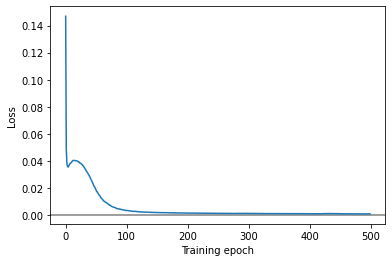

In [ ]:
# Plot loss
fig = plt.figure()
ax = fig.subplots(1, 1)
epochs = np.arange(n_epochs)
ax.plot(epochs, losses)
ax.axhline(0, c='0.5', zorder=-1)
ax.set_xlabel('Training epoch')
ax.set_ylabel('Loss')
plt.show(fig)
plt.close(fig)

In [ ]:
# Save to google drive
from google.colab import drive
drive.mount('/content/drive')

# Translate to Kanaka's name convention
res_dict = dict(
    J0 = wrec_init, J = wrec_final, 
    N = dim_rec, g=g, 
    R0 = rates_init.T, R = rates_final.T, 
    target_activity = target_R, 
    t = t,  target_t = target_t,
    nRunTot = n_epochs,
)

import os
from scipy.io import savemat
# This is the top level directory of your google drive.
data_dir = "drive/MyDrive/"
#######################################################
### Choose a file name
file_name = "pset_p3_torch_new.mat"
#######################################################
file = os.path.join(data_dir, file_name)
savemat(file, res_dict)


# A note: 
# Saving with 'savemat' is done here only to stick with the format. 
# It will put all saved quantities in matrix form. To undo this after loading,
# add the following lines of code to your notebook:
"""
# Obtain proper arrays, in case the matlab file has everything in matrix form)
t = t.squeeze()
target_t = target_t.squeeze()
N = int(N)
g = float(g)
"""